## Algorithm tests for Project 3

### Euler's and velocity Verlet method in co-planar solar system model

Showing only for x-coor. y-coor is analogous.

Acceleration is given for celestial body with mass $M_c$ as:

$$ a_{i} = \frac{F_G}{M_{c}} = G \frac{M_{other}}{r_i^2},$$

where $r_i$ is the distance between the celestial body and the other one.

**Euler's method:**

$$ x_{i+1} = x_i + hv_i + O(h^2) $$

$$ v_{i+1} = v_i + ha_i + O(h^2) $$


**Velocity Verlet formula:**

$$ x_{i+1} = x_i + hv_{i} + \frac{h^2}{2}a_i + O(h^3) $$

$$ v_{i+1} = v_i + \frac{h^2}{2}\left(a_{i+1} + a_{i}\right)$$


In [2]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

from numba import jit

%matplotlib inline

### Integration classes:

In [3]:
class Euler:
    def __init__(self, solar_system):
        self.sol = solar_system
        
        self.body = None
        self.sol_pos = None
        self.k = 0
        
        for i, body in enumerate(self.sol):
            body.past_accl = body.accl
            body.accl = np.asarray([0., 0.])
                    
            for j in range(len(self.sol)):
                if j != i:
                    body.calc_accl(self.sol[j])
    
    def __call__(self, nTimes, endTime):
        h = endTime / nTimes
        self.sol_pos = np.zeros((len(self.sol), nTimes, 2))
        
        for k in range(nTimes):
            self.k = k
            self.integrate(h)
    
    def integrate(self, h):
        for i, body in enumerate(self.sol):
            self.body = body
            self.integrate_pos(h)
            
            body.past_accl = body.accl
            body.accl = np.asarray([0., 0.])
            
            for j in range(len(self.sol)):
                if j != i:
                    body.calc_accl(self.sol[j])
                               
            self.integrate_vel(h)
            
            if self.sol_pos is not None:
                self.sol_pos[i, self.k, :] = self.body.pos
    
    def integrate_pos(self, h):
        self.body.pos += h * self.body.vel
    
    def integrate_vel(self, h):
        self.body.vel += h * self.body.accl
    
    @property
    def system_pos(self):
        return self.sol_pos
        
        
class Verlet(Euler):
    def integrate_pos(self, h):
        self.body.pos += h * self.body.vel + 0.5 * h * h * self.body.accl
    
    def integrate_vel(self, h):
        self.body.vel += 0.5 * h * (self.body.accl + self.body.past_accl)

### Acceleration methods:

In [4]:
class Acceleration:
    def __init__(self, this_body, *args):
        self.G = 4 * np.pi * np.pi
        self.body = this_body
    
    def __call__(self, other_body):
        r, direction = self.getRandDir(other_body)
        self.body.accl += (self.G * other_body.mass / r**2) * direction
    
    def getRandDir(self, other_body):
        r = np.linalg.norm(other_body.pos - self.body.pos)
        direction = (other_body.pos - self.body.pos) / r
        return r, direction

        
class BetaAcceleration(Acceleration):
    def __init__(self, this_body, beta):
        self.beta = beta
        Acceleration.__init__(self, this_body)
    
    def __call__(self, other_body):
        r, direction = self.getRandDir(other_body)
        self.body.accl += (self.G * other_body.mass / r**self.beta) * direction
        
        
class GenAcceleration(Acceleration):
    def __init__(self, this_body, *args):
        self.l = np.cross(this_body.pos, this_body.vel)
        self.c2 = 63239.7263**2
        
        Acceleration.__init__(self, this_body)
    
    def __call__(self, other_body):
        r, direction = self.getRandDir(other_body)
        r2 = r * r
        self.body.accl += ((1 + 3*self.l**2/(r2 * self.c2)) * self.G * \
                          other_body.mass / r2) * direction
    
    
class NoAcceleration(Acceleration):
    def __call__(self, other_body):
        self.body.accl += 0.0

### Celestial body class:

In [5]:
class Body:
    def __init__(self, init_pos, init_vel, mass, accl_method, *accl_args):              
        self._pos = np.asarray(init_pos)
        self._vel = np.asarray(init_vel)
        self._mass = mass
        
        self._accl = np.array([0.0, 0.0])
        self._past_accl = None
        
        self.am = accl_method(self, *accl_args)
        
    def __call__(self):
        print ("Pos: {}, Vel: {}, Accl: {}".format(self.pos,
            self.vel, self.accl))
        print ("Accl Type: {}".format(self.am.__class__.__name__))
    
    def calc_accl(self, other_body):
        self.am(other_body)
    
    @property
    def accl(self):
        return self._accl
    
    @accl.setter
    def accl(self, value):
        self._accl = value
    
    @property
    def past_accl(self):
        return self._past_accl
    
    @past_accl.setter
    def past_accl(self, value):
        self._past_accl = value
    
    @property
    def pos(self):
        return self._pos
    
    @pos.setter
    def pos(self, value):
        self._pos = value
    
    @property
    def vel(self):
        return self._vel
    
    @vel.setter
    def vel(self, value):
        self._vel = value
    
    @property
    def mass(self):
        return self._mass     

### Testing the Algorithm for two-body systems
#### Integration method:

In [6]:
IntegrationMethod = [Euler, Verlet]

for IM in IntegrationMethod:
    earth = Body([1., 0.], [0., 2. * np.pi], 1e-6, GenAcceleration)
    sun = Body([0., 0.], [0., 0.], 1.0, GenAcceleration)

    sol = [earth, sun]

    integrator = IM(sol)
    integrator(20000, 10)
    
    print ("Integration method: {}".format(IM.__name__))
    print("EARTH:")
    earth()
    print("SUN:")
    sun()
    print("---------------------------")

Integration method: Euler
EARTH:
Pos: [ 1.00000007e+00 -2.65635183e-04], Vel: [2.06382038e-03 6.28318546e+00], Accl: [-3.94784072e+01  1.29673651e-02]
Accl Type: GenAcceleration
SUN:
Pos: [-1.13440754e-13  6.28321200e-05], Vel: [-2.06382033e-09  4.87546909e-13], Accl: [ 3.94784060e-05 -1.29673647e-08]
Accl Type: GenAcceleration
---------------------------
Integration method: Verlet
EARTH:
Pos: [ 1.00000039e+00 -3.30934333e-05], Vel: [6.02716123e-04 6.28318404e+00], Accl: [-3.94783874e+01  3.78697550e-03]
Accl Type: GenAcceleration
SUN:
Pos: [-4.39608778e-13  6.28318874e-05], Vel: [-6.02716122e-10  1.88925028e-12], Accl: [ 3.94783863e-05 -3.78697538e-09]
Accl Type: GenAcceleration
---------------------------


#### Acceleration types

EARTH:
Pos: [ 0.99978923 -0.02065886], Vel: [0.13018938 6.28182399], Accl: [-39.46962959   0.81805078]
Accl Type: Acceleration
EARTH:
Pos: [-0.95756012 -0.28927955], Vel: [ 1.8171395  -6.01256936], Accl: [37.7544923  11.40812029]
Accl Type: BetaAcceleration
EARTH:
Pos: [ 0.99978931 -0.02065514], Vel: [0.13016603 6.28182447], Accl: [-39.4696338    0.81790403]
Accl Type: GenAcceleration


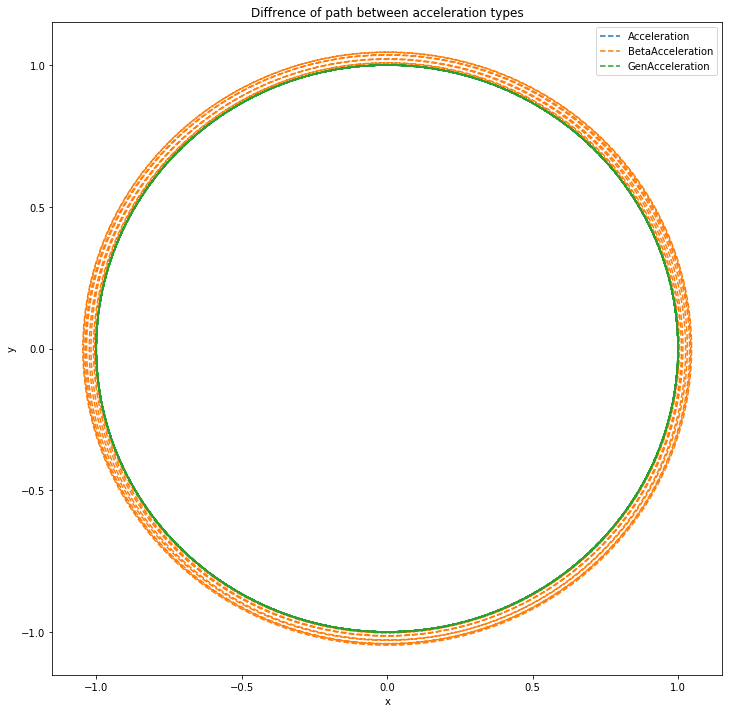

In [7]:
AcclTypes = [Acceleration, BetaAcceleration, GenAcceleration]
extra_args = [None, 2.99, None]

plt.figure(figsize=(12,12))
plt.title("Diffrence of path between acceleration types")
plt.xlabel("x")
plt.ylabel("y")


for ea, AT in zip(extra_args, AcclTypes):
    earth = Body([1., 0.], [0., 2. * np.pi], 1e-6, AT, ea)
    sun = Body([0., 0.], [0., 0.], 1.0, AT, ea)
    
    sol = [earth, sun]
    
    integrator = Verlet(sol)
    integrator(2000, 10)

    earth_pos = integrator.system_pos[0, :, :]

    plt.plot(earth_pos[:, 0], earth_pos[:, 1], "--",label=AT.__name__)
    
    print("EARTH:")
    earth()
        
plt.legend()

In [7]:
earth = Body([1., 0.], [0., 2. * np.pi], 1e-6, Acceleration)
sun = Body([0., 0.], [0., 0.], 1.0, Acceleration)

sol = [earth, sun]

integrator = Euler(sol)
integrator(20000, 10)

earth_pos = integrator.system_pos[0, :, :]
sun_pos = integrator.system_pos[1, :, :]

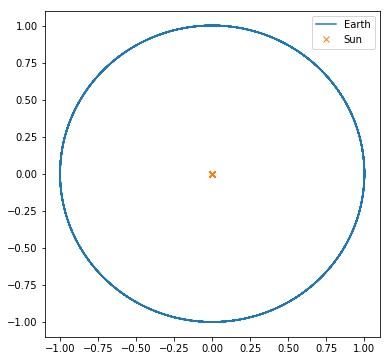

In [8]:
plt.figure(figsize=(6,6))
plt.plot(earth_pos[:, 0], earth_pos[:, 1], label='Earth')
plt.plot(sun_pos[:, 0], sun_pos[:, 1], 'x', label="Sun")
plt.legend()

### Perihelion
Checking the case of Mercury's perihelion without general relativity taken into consideration in the acceleration:

In [ ]:
from scipy.signal import argrelextrema

mercury = Body([0.3075, 0.], [0., 12.44], 1.65e-7, Acceleration)
sun = Body([0., 0.], [0., -2.0526e-6], 1.0, Acceleration)

sol = [mercury, sun]

integrator = Verlet(sol)
integrator(10000000, 100)

mercury_pos = integrator.system_pos[0, :, :]
sun_pos = integrator.system_pos[1, :, :]

rposs = np.linalg.norm(mercury_pos, 2, axis=1)
local_minima_idx = argrelextrema(rposs, np.less)

for lmi in local_minima_idx:
    print(rposs[lmi])

plt.figure(figsize=(6,6))
plt.plot(mercury_pos[:, 0], mercury_pos[:, 1], label='Mercury')
plt.plot(sun_pos[:, 0], sun_pos[:, 1], 'x', label="Sun")
plt.legend()

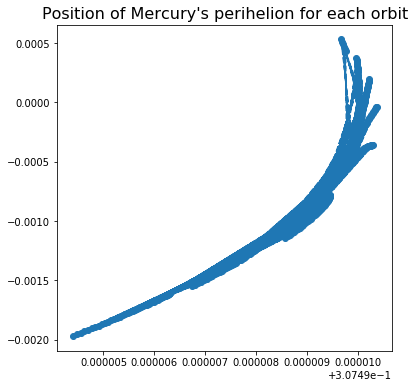

In [22]:
# Perihelion position
perx = mercury_pos[:,0].take(local_minima_idx)
pery = mercury_pos[:,1].take(local_minima_idx)

plt.figure(figsize=(6,6))
plt.title(r"Position of Mercury's perihelion for each orbit",
         fontsize=16)
plt.plot(perx.T, pery.T, "--o")
plt.show()

In [23]:
arcsecond = np.pi / 648000

peri_phi = np.arctan2(pery, perx)

arc_diff = np.diff(peri_phi) / arcsecond
arc_diff

peri_phi_arcsec = peri_phi[0] / arcsecond
peri_phi_arcsec[-1] - peri_phi_arcsec[0]

-492.8779367209467